# Borehole chemistry and radar attenuation to temperature

This notebook does three things:

1. Loads an radar attenuation rates CSV
2. Loads a borehole chemistry CSV, for example `waisdivide_imp.csv`
3. Runs `attenRateToTemperature` to estimate depth averaged temperature from attenuation

The notebook is written so you can choose either:

* chemistry mode, using `acid [mol/L]` and `sscl [mol/L]`
* conductivity mode, using `conductivity [S/m]` directly

Edit the file paths and column names in the configuration cell below.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.dpi"] = 140

import sys
sys.path.append('../src')
import atten_temp_functions

## Configuration

Update the file paths and column names here.

This notebook assumes:

* attenuation CSV has a depth column and an attenuation column
* borehole CSV has fields like  
  `depth [m]`, `acid [mol/L]`, `conductivity [S/m]`, `sscl [mol/L]`


In [ ]:
# File paths
attenuation_data = Path("../data/FullDataSet_Randomized.txt")
borehole_data = Path("../data/waisdivide_imp.csv")


# Attenuation CSV column names
att_depth_col = "depth [m]"
att_rate_col = "attenuation_rate"

# Borehole chemistry CSV column names
bore_depth_col = "depth [m]"
bore_acid_col = "acid [mol/L]"
bore_cond_col = "conductivity [S/m]"
bore_sscl_col = "sscl [mol/L]"

# Merge settings
use_nearest_depth_merge = True
depth_tolerance_m = 5.0

# Choose one mode
# "chem" uses acid and sscl
# "cond" uses conductivity directly
mode = "chem"

# Output
output_dir = Path("../outputs")
output_dir.mkdir(parents=True, exist_ok=True)
# Make borehole tag from filename
borehole_tag = borehole_data.stem.removesuffix("_imp")
# Build output filename
output_name = f"attenuation_temperature_{borehole_tag}_{mode}.csv"
output_path = output_dir / output_name


# Optional model parameter overrides
func_kwargs = {
    "sigma0": 6.6e-6,
    "Epure": 0.55 * 1.602176634e-19,
    "E_Hp": 0.20 * 1.602176634e-19,
    "E_ssCl": 0.19 * 1.602176634e-19,
    "mu_Hp": 3.2,
    "mu_ssCl": 0.43,
}

attenuation_data, borehole_data, mode


(PosixPath('../example_data/FullDataSet_Randomized.txt'),
 PosixPath('../example_data/waisdivide_imp.csv'),
 'chem')

## Load the depth averaged attenuation rates

In [9]:
att_df = pd.read_csv(attenuation_data)
att_df = att_df.rename(columns={
    "x": "x",
    "y": "y",
    "atten_rate_C0": "atten_rate_C0"
})

att_df.head()


,x,y,aggregate_power,peak_power,atten_rate_C0,atten_rate_C.25,atten_uncertainty_C0,atten_uncertainty_C.25,reflectivity,reflectivity_sensitivity_test,reflectivity_variability,scattering_error
0,-1.208555e+06,-578181.65135,104.865172,94.542784,7.542318,0.632382,8.994948,0.696764,-11.005804,-11.816787,NaN,3.472389
1,-1.208551e+06,-578197.38140,102.898135,91.002152,7.542318,0.632382,8.994948,0.696764,-12.934520,-13.738122,NaN,5.045983
2,-1.208543e+06,-578228.85235,104.072383,93.956148,7.542318,0.632382,8.994948,0.696764,-11.703500,-12.496168,NaN,3.266235
3,-1.208535e+06,-578260.31135,102.281378,90.493025,7.542318,0.632382,8.994948,0.696764,-13.477697,-14.267128,NaN,4.938353
4,-1.208531e+06,-578276.04100,103.322084,92.818979,7.542318,0.632382,8.994948,0.696764,-12.490315,-13.290016,NaN,3.653105


In [16]:
att_df["atten_rate_C0"].isna().any()

True

## Load the borehole chemistry CSV

In [10]:
bh_df = pd.read_csv(borehole_data)
bh_df = bh_df.rename(columns={
    bore_depth_col: "depth_m",
    bore_acid_col: "acid_molL",
    bore_cond_col: "conductivity_Sm",
    bore_sscl_col: "sscl_molL",
})

required_bore_cols = ["depth_m", "acid_molL", "conductivity_Sm", "sscl_molL"]
missing_bore = [c for c in required_bore_cols if c not in bh_df.columns]
if missing_bore:
    raise ValueError(f"Missing borehole columns: {missing_bore}")

for col in required_bore_cols:
    bh_df[col] = pd.to_numeric(bh_df[col], errors="coerce")

bh_df = bh_df.dropna(subset=["depth_m"]).sort_values("depth_m").reset_index(drop=True)

bh_df.head()


,depth_m,acid_molL,conductivity_Sm,sscl_molL
0,577.0000,NaN,0.000004,1.492362e-07
1,577.0262,5.089428e-07,0.000006,3.135643e-07
2,577.0505,5.232883e-07,0.000006,4.646887e-07
3,577.0748,3.954110e-07,0.000005,2.364862e-07
4,577.0991,4.414667e-07,0.000006,3.537190e-07


In [28]:
mode='cond'

## Run the temperature inversion

In [33]:
if mode == "chem":
    chem_imp = {
        "molar_Hp": bh_df["acid_molL"].mean(),
        "molar_ssCl": bh_df["sscl_molL"].mean(),
    }
    Tavg_K, terms = atten_temp_functions.attenRateToTemperature(
        att_df["atten_rate_C0"].to_numpy(),
        chem_imp=chem_imp,
        return_terms=True,
        **func_kwargs
    )

elif mode == "cond":
    Tavg_K, terms = atten_temp_functions.attenRateToTemperature(
        att_df["atten_rate_C0"].to_numpy(),
        cond=bh_df["conductivity_Sm"].mean(),
        return_terms=True,
        Tref = 251,
        **func_kwargs
    )

elif mode == "pure":
    Tavg_K, terms = atten_temp_functions.attenRateToTemperature(
        att_df["atten_rate_C0"].to_numpy(),
        return_terms=True,
        **func_kwargs
    )

else:
    raise ValueError("mode must be one of: 'chem', 'cond', 'pure'")


nan_mask = att_df["atten_rate_C0"].isna().to_numpy()
Tavg_K = np.asarray(Tavg_K, dtype=float)
Tavg_K[nan_mask] = np.nan

Tavg_C = Tavg_K - 273.15

## Make output dataframe

In [34]:
output_df = pd.DataFrame({
    "x": att_df["x"],
    "y": att_df["y"],
    "atten_rate": att_df["atten_rate_C0"],
    "Tavg_C": Tavg_C,
})

output_df.head()

,x,y,atten_rate,Tavg_C
0,-1.208555e+06,-578181.65135,7.542318,-34.181498
1,-1.208551e+06,-578197.38140,7.542318,-34.181498
2,-1.208543e+06,-578228.85235,7.542318,-34.181498
3,-1.208535e+06,-578260.31135,7.542318,-34.181498
4,-1.208531e+06,-578276.04100,7.542318,-34.181498


## Save output

In [19]:
# Save
output_df.to_csv(output_path, index=False)
print(f"Saved output to: {output_path.resolve()}")

Saved output to: /Users/elizadawson/projects/ice_attenuation_temperature/outputs/attenuation_temperature_waisdivide_chem.csv


## Plot the results

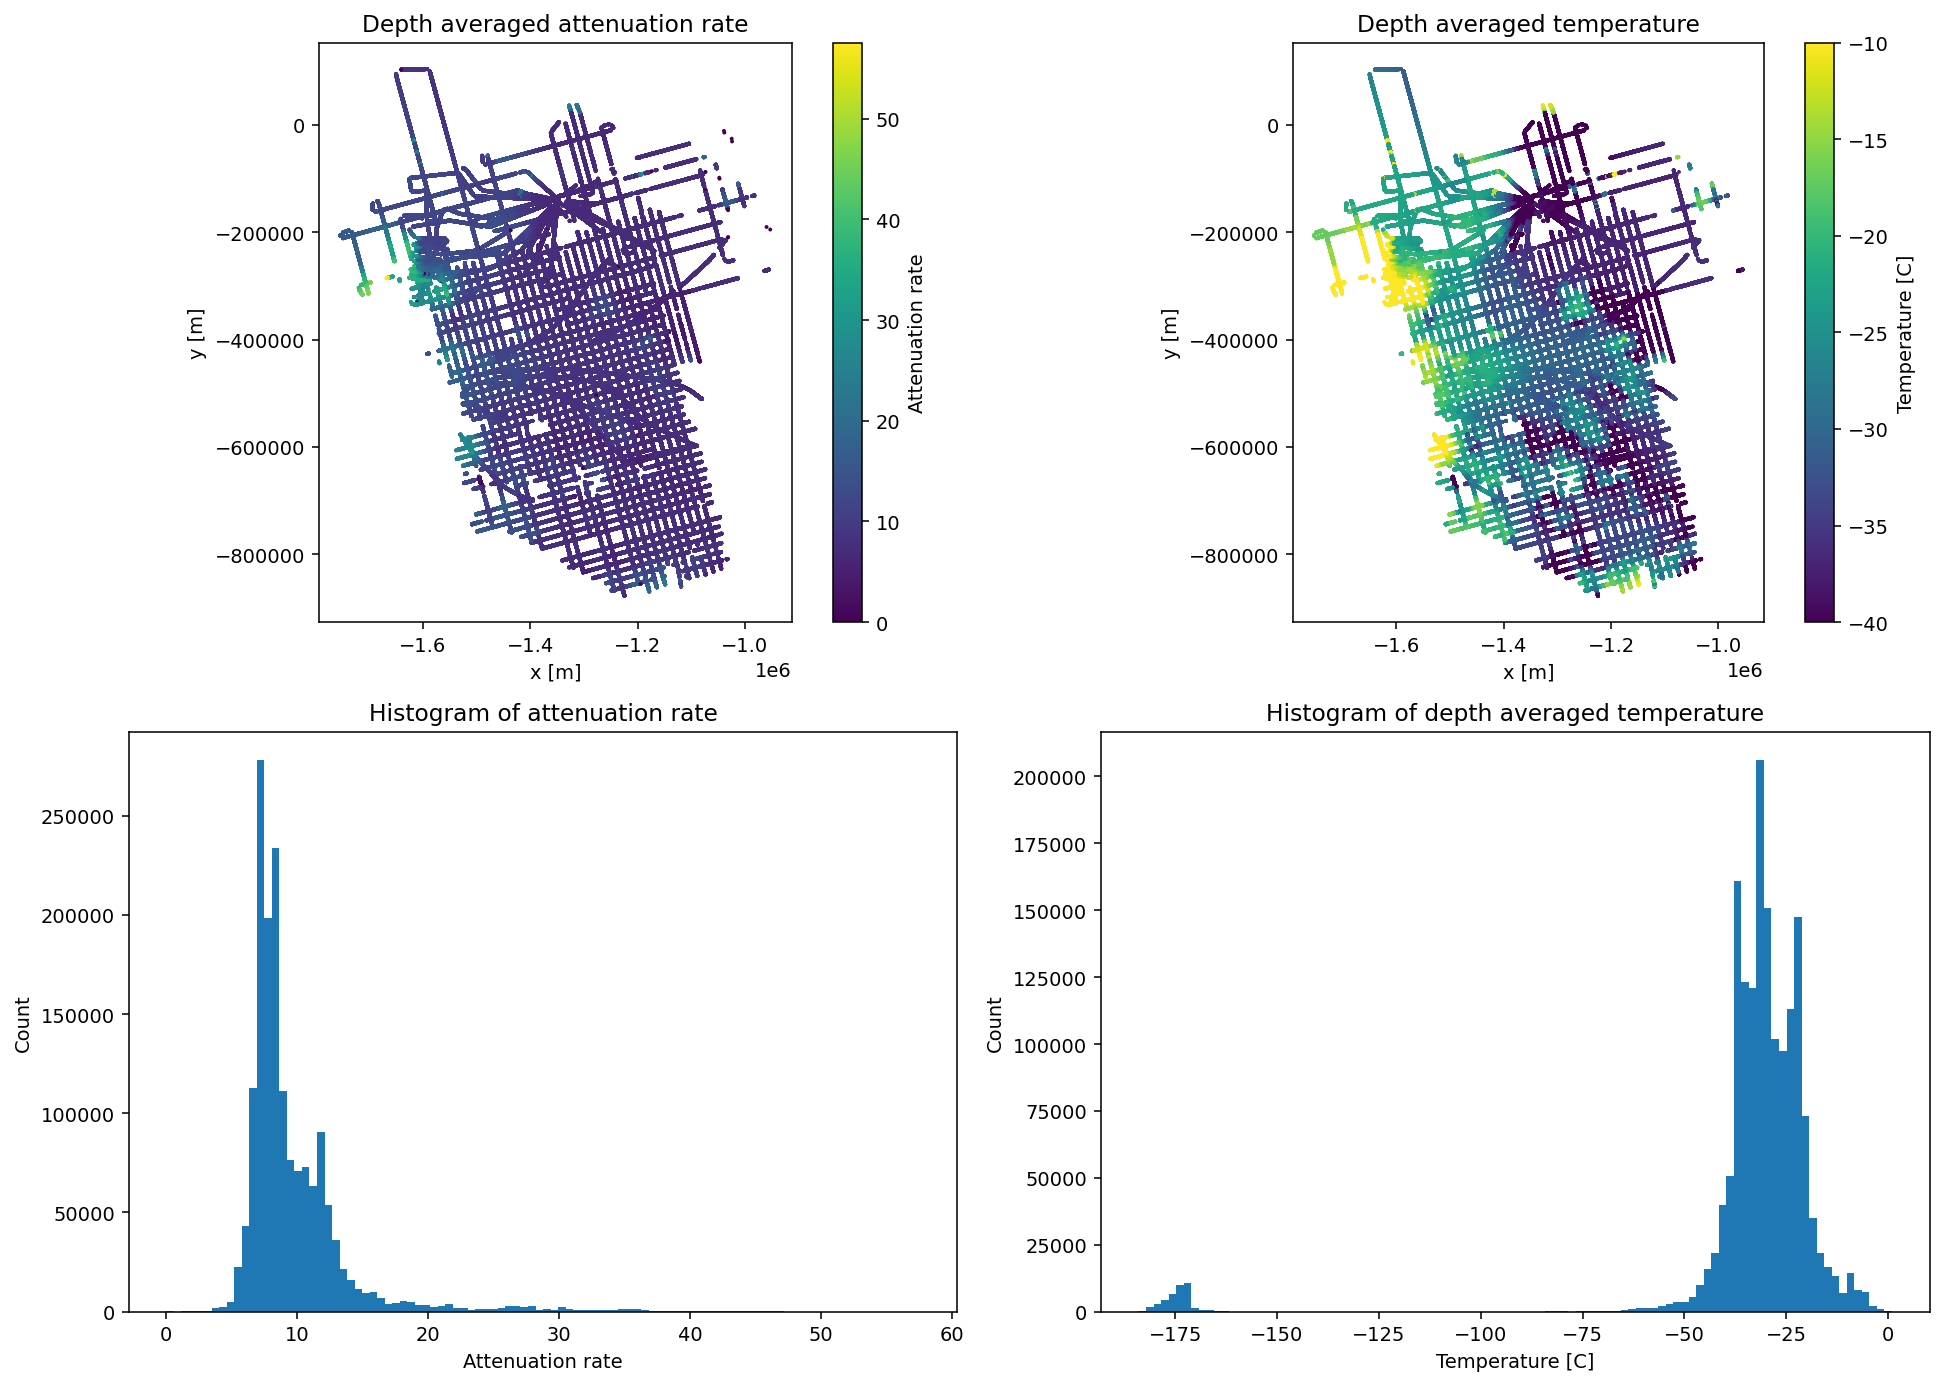

In [35]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left, attenuation map
sc1 = axes[0, 0].scatter(
    att_df["x"],
    att_df["y"],
    c=att_df["atten_rate_C0"],
    s=1,
)
axes[0, 0].set_title("Depth averaged attenuation rate")
axes[0, 0].set_aspect("equal")
axes[0, 0].set_xlabel("x [m]")
axes[0, 0].set_ylabel("y [m]")
cbar1 = plt.colorbar(sc1, ax=axes[0, 0])
cbar1.set_label("Attenuation rate")

# Top right, temperature map
sc2 = axes[0, 1].scatter(
    att_df["x"],
    att_df["y"],
    c=Tavg_C,
    s=1,
    vmin=-40,
    vmax=-10,
)
axes[0, 1].set_title("Depth averaged temperature")
axes[0, 1].set_aspect("equal")
axes[0, 1].set_xlabel("x [m]")
axes[0, 1].set_ylabel("y [m]")
cbar2 = plt.colorbar(sc2, ax=axes[0, 1])
cbar2.set_label("Temperature [C]")

# Bottom left, attenuation histogram
axes[1, 0].hist(
    att_df["atten_rate_C0"].dropna(),
    bins=100
)
axes[1, 0].set_title("Histogram of attenuation rate")
axes[1, 0].set_xlabel("Attenuation rate")
axes[1, 0].set_ylabel("Count")

# Bottom right, temperature histogram
axes[1, 1].hist(
    np.asarray(Tavg_C)[np.isfinite(Tavg_C)],
    bins=100
)
axes[1, 1].set_title("Histogram of depth averaged temperature")
axes[1, 1].set_xlabel("Temperature [C]")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()